In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import configparser
from Bio import SeqIO, pairwise2

%matplotlib inline

In [53]:
class FastQ():
    
    def __init__(self, filename):
        self.filename = filename
        self._sequences = {}
    
    def parse_file(self, num_lines=100):
        with open(self.filename, 'r') as f:
            data = []

            for i, record in enumerate(SeqIO.parse(self.filename, "fastq")):
                data.append(str(record.seq))
                if i == num_lines:
                    break
        
        self._sequences = data
        return self._sequences

In [54]:
config = configparser.ConfigParser()
config.read('config.ini')
Ndata = config['data']['ndata']
Tdata = config['data']['tdata']

fastN = FastQ(Ndata)
fastT = FastQ(Tdata)

In [55]:
fastN.parse_file(num_lines=10000)
fastT.parse_file(num_lines=10000)

['ATAGAAGCTCTATCTTTCTCTAATAGTAAAATTCTTGTATAAATAATTTGTAACTCACCCGTTTGGATCTCAATTCACTGGTCAATAAACTAGATTCTTCA',
 'CGGACAGGGCCCTGGACTTCGGGTANNTNACTCAGGACATGATTGATGACTACGAGCCGGCCCTCATGTTCAGCATCCCCAGGCTGGCCATCGTGTGGTGN',
 'TGTAAGATATTCTTTTACCTGAGCATTCTGTAGAATGTTGTTAACCAAGACAACGCGTCGCCGGGCATTAAGTAGCTTCTTAACATAGGGGTCAAGATCCA',
 'CAATAACTATTATGGAAACACCCTGAGGGAAAAAGTCTTAAATGAGTAAAATGAGAACAAAAGCAGAAAGGAAATTCAGGAACTATTTTCAAAATTCAAAT',
 'CAAGGCATTTCACTGAAAGCAGAAGCTGTCTCAGTCAAGAAAGAATCAGAAGATCCTAATTACTATCAATATAATATGCAAGGTAATACTGTTTGATAATA',
 'CCGGGTAGAGCTGTCCCACTTCCCATCGACCTGTGTCTTGGACACTAGCACCCTCCCGGCACAGAAGCGCCAGCTGCCCCTCTGGAAATCCAAGGGCCCTC',
 'TTCACTCCCTGTAGTTCCACTACGTCCGAAATCGGGCATGCTTCTTTGTCCAGGATGCTAGCGCTGCCTCCGCATTGAAGGATGTCAGTTATAAGATTTAT',
 'TCTGCAATTTGAAGAATTTAGTTTGANGNCTACTCAGAAGATTCAGTAAGTAATTTCACAGTTCTTGATTATGAAACCTAAATATATGTTATGTTTTCTGN',
 'ATCGCGTCATCGTTTTTGATGGTGTTCCATCTAAGAACACAGTTGCAAACAGGTAAAATTACTTTTTAATATGTTCAAAGTAATTCATTTTAAATTTTCCA',
 'AATTACATTTGGAAGCAAAATAGGAATCTAATTCTGAATTCTAT

In [71]:
# Storing the frequencies of each different nucleotide to analyze the percentage changes from healthy to cancerous genomes
T_dicts = []
N_dicts = []

for ix, key in enumerate(fastT._sequences):
    T_dicts.append(Counter(fastT._sequences[ix]))

for ix, key in enumerate(fastN._sequences):
    N_dicts.append(Counter(fastN._sequences[ix]))
    
# Starting with the diseased genome, create a dict with ACGT keys that store the number of occurences as values
T_frequencies = {}
for d in T_dicts:
    for key in d:
        if key not in T_frequencies and key in 'ACGT':
            T_frequencies[key] = d[key]
        elif key not in 'ACGT':
            pass
        else:
            T_frequencies[key] += d[key]

# From these counts generate frequencies and manipulate the frequencies dictionary to get the final frequencies
T_frequencies['total'] = sum([T_frequencies[key] for key in T_frequencies])
print("T:", sorted(T_frequencies))
print(sorted([T_frequencies[key] / T_frequencies['total'] for key in T_frequencies if key != 'total']))

# Do the same for the non-diseased data for comparision of genomic changes
N_frequencies = {}
for d in N_dicts:
    for key in d:
        if key not in N_frequencies and key in 'ACGT':
            N_frequencies[key] = d[key]
        elif key not in 'ACGT':
            pass
        else:
            N_frequencies[key] += d[key]
    
N_frequencies['total'] = sum([N_frequencies[key] for key in N_frequencies])
print("N:", sorted(N_frequencies))
print(sorted([N_frequencies[key] / N_frequencies['total'] for key in N_frequencies if key != 'total']))
print(N_frequencies)

T: ['A', 'C', 'G', 'T', 'total']
[0.22122191397811136, 0.22535845753854866, 0.27535439822102886, 0.2780652302623111]
N: ['A', 'C', 'G', 'T', 'total']
[0.22117406646152385, 0.22855207974432393, 0.2733646988004293, 0.27690915499372293]
{'C': 230844, 'T': 279686, 'total': 1010028, 'G': 223392, 'A': 276106}


## Neural Net
First, its important to classify exactly WHAT changes in the genome identify infiltrating
duct adenocarcinoma. This is done by modeling the changing patterns from normal to diseased states in the genome to localize exactly where in the genome these changes are occuring. 

We can train our neural net to see these discrepancies and can then have it predict for real cases. 

In [98]:
# Parse the fastq genomic sequence file to allow for point-point comparitive genomics to analyze 
# what regions of the DNA changed the most

healthy_seq = fastN.parse_file(num_lines=10000)
cancer_seq = fastT.parse_file(num_lines=10000)

scores = []

for i, key in enumerate(healthy_seq):
    alignments = pairwise2.align.globalxx(healthy_seq[i], cancer_seq[i])
    scores.append(alignments[0][2])

print(scores)

[59.0, 68.0, 66.0, 61.0, 59.0, 64.0, 63.0, 59.0, 56.0, 63.0, 63.0, 66.0, 61.0, 60.0, 62.0, 63.0, 62.0, 60.0, 60.0, 51.0, 61.0, 59.0, 61.0, 61.0, 62.0, 66.0, 61.0, 63.0, 60.0, 56.0, 61.0, 62.0, 62.0, 63.0, 61.0, 62.0, 52.0, 63.0, 61.0, 60.0, 67.0, 63.0, 64.0, 59.0, 53.0, 56.0, 64.0, 49.0, 62.0, 62.0, 62.0, 62.0, 62.0, 63.0, 61.0, 56.0, 60.0, 60.0, 63.0, 65.0, 58.0, 62.0, 61.0, 62.0, 64.0, 65.0, 65.0, 58.0, 60.0, 54.0, 55.0, 57.0, 61.0, 61.0, 64.0, 61.0, 58.0, 62.0, 60.0, 55.0, 62.0, 64.0, 57.0, 61.0, 61.0, 61.0, 56.0, 65.0, 63.0, 60.0, 62.0, 62.0, 56.0, 62.0, 62.0, 58.0, 58.0, 65.0, 61.0, 60.0, 61.0, 60.0, 64.0, 65.0, 62.0, 59.0, 59.0, 62.0, 63.0, 53.0, 63.0, 63.0, 60.0, 62.0, 49.0, 62.0, 65.0, 58.0, 63.0, 64.0, 63.0, 57.0, 63.0, 64.0, 60.0, 62.0, 57.0, 64.0, 58.0, 62.0, 57.0, 63.0, 59.0, 59.0, 53.0, 65.0, 64.0, 56.0, 60.0, 59.0, 62.0, 67.0, 55.0, 65.0, 61.0, 59.0, 55.0, 63.0, 64.0, 51.0, 56.0, 66.0, 63.0, 58.0, 62.0, 60.0, 64.0, 63.0, 63.0, 57.0, 64.0, 48.0, 55.0, 51.0, 61.0, 57.0, 60.

In [96]:
# Creating a DataFrame to store the frequency of each of the keys in diseased and healthy states, as well as 
# as the scores for the comparisons between the diseased and healthy comparisons, which signify the 
# number of similar nucleotides

df = pd.DataFrame([N_frequencies])
df.append([T_frequencies])



,A,C,G,T,total
0,276106,230844,223392,279686,1010028
0,278114,227617,223439,280852,1010022


(array([  1.00000000e+00,   1.00000000e+00,   8.00000000e+00,
          2.30000000e+01,   1.14000000e+02,   4.91000000e+02,
          1.95700000e+03,   4.30000000e+03,   2.79600000e+03,
          3.10000000e+02]),
 array([ 31.,  35.,  39.,  43.,  47.,  51.,  55.,  59.,  63.,  67.,  71.]),
 <a list of 10 Patch objects>)

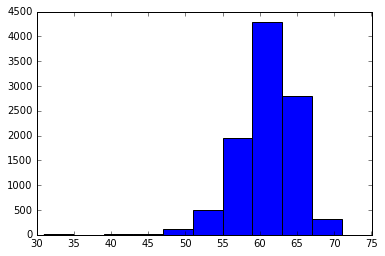

In [99]:
plt.hist(scores)